# Sequencing - execution times for LD

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import psycopg2
import pandas as pd

In [86]:
# Connecting to Redshift

# Redshift Connection 
# Create a global variable for the database connection
connection = None

# Connect to Amazon Redshift
def connect_to_redshift():
    try:
        conn = psycopg2.connect(
        host='dwh-redshift.sandbox.verses.build',
            port='5439',
            database='ds_dwh',
            user='dwh_operator',
            password='G$@4333sHK^RuuYA'
        )
        print("Connected to Redshift")
        return conn
    except psycopg2.Error as e:
        print("Error connecting to Redshift:", e)
        return None

# Execute SQL query 
def execute_query(query):
    global connection
    try:
        if connection is None or connection.closed != 0:
            connection = connect_to_redshift()
        connection.autocommit = False  # Disable autocommit
        cur = connection.cursor()
        cur.execute(query)
        rows = cur.fetchall()
        column_names = [desc[0] for desc in cur.description]
        cur.close()
        connection.commit()  # Explicitly commit the transaction
        return rows, column_names
    except psycopg2.Error as e:
        connection.rollback()  # Rollback the transaction on error
        print("Error executing query:", e)
        return None, None
    finally:
        connection.autocommit = True  # Enable autocommit after query execution

# A function to create Temp Table 
def cretae_temp_table(query):
    global connection
    try:
        if connection is None or connection.closed != 0:
            connection = connect_to_redshift()
        connection.autocommit = False  # Disable autocommit
        cur = connection.cursor()
        cur.execute(query)
        cur.close()
        connection.commit()  # Explicitly commit the transaction
    except psycopg2.Error as e:
        connection.rollback()  # Rollback the transaction on error
        print("Error executing query:", e)
        return None, None
    finally:
        connection.autocommit = True  # Enable autocommit after query execution
        
# Example SQL query
query = """SELECT * FROM raw_aspire_picks 
LIMIT 100
""" 

# Create DataFrame
results, columns = execute_query(query)
df = pd.DataFrame(results, columns=columns)

Connected to Redshift


In [97]:
# RefPickData
# read from raw_aspire_picks
query = """DROP TABLE IF EXISTS RefPickData;

CREATE TEMP TABLE RefPickData AS
SELECT 
facilityname as facility_name,
employeenumber as employee_number,
assignmentnumber as assignment_number,
assignmentstarttime as assignment_start_time,
assignmentendtime as assignment_end_time,
picktypedescription as pick_type,
fastpicked as fast_picked,
taskstartdate as task_start_time,
taskenddate as task_end_time,
itemnumber as sku,
quantitypicked as quantity_picked,
taskstatusdescription as task_status,
fromlocation as location,
SPLIT_PART(fromlocation, '-', 1) AS warehouse_id,
SPLIT_PART(fromlocation, '-', 2) AS asile,
SPLIT_PART(fromlocation, '-', 3) AS section,
SPLIT_PART(fromlocation, '-', 4) AS level,
SPLIT_PART(fromlocation, '-', 5) AS column_num,
name as brand,
CASE WHEN subdocumenttype = '' THEN 'other' ELSE subdocumenttype END as order_type,
'NRI' as client
FROM raw_aspire_picks
WHERE 
DATE_TRUNC('day', taskenddate) >= '2023-01-01'
AND 
DATE_TRUNC('day', taskenddate) <= '2023-07-01'
AND 
facilityname = 'LD'
AND 
asile IN ('02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13')
AND
section IN ('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16')
AND 
"""

# read from stg_picks
query = """DROP TABLE IF EXISTS RefPickData;
CREATE TEMP TABLE RefPickData AS
SELECT 
facility_name, 
external_employee_id as employee_number, 
external_assignment_id as assignment_number, 
assignment_start_time,
assignment_end_time,
pick_type,
fast_picked,
task_start_time,
task_end_time,
sku,
quantity_picked,
task_status,
location,
SPLIT_PART(location, '-', 1) AS warehouse_id,
SPLIT_PART(location, '-', 2) AS asile,
SPLIT_PART(location, '-', 3) AS section,
SPLIT_PART(location, '-', 4) AS level,
SPLIT_PART(location, '-', 5) AS column_num,
brand,
CASE WHEN order_type = '' THEN 'other' ELSE order_type END as order_type,
client
FROM stg_picks
WHERE 
--DATE_TRUNC('day', task_end_time) >= '2023-01-01'
--AND 
--DATE_TRUNC('day', task_end_time) <= '2023-07-01'
--AND 
facility_name = 'LD'
--AND 
--asile IN ('02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13')
--AND
--section IN ('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16')
"""

cretae_temp_table(query)

query = """SELECT * FROM RefPickData"""

# Execute the query
results, columns = execute_query(query)
df = pd.DataFrame(results, columns=columns)
total_num_records, _ = df.shape
total_num_records

4533324

In [98]:
# Find Duplicated Records 
query = """WITH duplicates AS (
    SELECT  facility_name,
            employee_number,
            assignment_number,
            assignment_start_time,
            assignment_end_time,
            pick_type,
            fast_picked,
            task_start_time,
            task_end_time,
            sku, 
            quantity_picked,
            task_status,
            location,
            asile,
            section,
            level,
            column_num,
            brand,
            order_type,
           ROW_NUMBER() OVER (PARTITION BY facility_name,
            employee_number,
            assignment_number,
            assignment_start_time,
            assignment_end_time,
            pick_type,
            fast_picked,
            task_start_time,
            task_end_time,
            sku, 
            quantity_picked,
            task_status,
            location,
            asile,
            section,
            level,
            column_num,
            brand,
            order_type) AS row_num
    FROM RefPickData)
    
    SELECT * FROM duplicates
    WHERE row_num > 1
    order by assignment_start_time
    """

results, columns = execute_query(query)
df = pd.DataFrame(results, columns=columns)
if len(df)>0:
    print("there is duplciated records")
df.head()

,facility_name,employee_number,assignment_number,assignment_start_time,assignment_end_time,pick_type,fast_picked,task_start_time,task_end_time,sku,quantity_picked,task_status,location,asile,section,level,column_num,brand,order_type,row_num


In [99]:
# get the list of all historical assignments 
query = """SELECT 
employee_number, 
assignment_start_time, 
assignment_end_time, 
assignment_number, 
EXTRACT(epoch FROM (assignment_end_time - assignment_start_time)) as assignment_time, 
count(*) as assignment_length,
min(task_start_time) as task_start_time, 
max(task_end_time) as task_end_time
FROM RefPickData
GROUP BY employee_number, assignment_start_time, assignment_end_time, assignment_number
--HAVING task_start_time between '2020-12-15' and '2022-05-12'
ORDER BY task_start_time DESC"""
results, columns = execute_query(query)
historical_assginment = pd.DataFrame(results, columns=columns)
historical_assginment.head()

,employee_number,assignment_start_time,assignment_end_time,assignment_number,assignment_time,assignment_length,task_start_time,task_end_time
0,07899,2023-09-14 13:54:08.530000+00:00,2023-09-14 13:58:13.893000+00:00,20741186,245.0,6,2023-09-14 13:55:37.840000+00:00,2023-09-14 13:58:13.753000+00:00
1,05064,2023-09-14 13:54:20.610000+00:00,2023-09-14 13:56:05.330000+00:00,20741188,104.0,2,2023-09-14 13:55:06.067000+00:00,2023-09-14 13:55:57.873000+00:00
2,06038,2023-09-14 13:40:22.263000+00:00,2023-09-14 13:59:01.143000+00:00,20740905,1118.0,18,2023-09-14 13:41:12.367000+00:00,2023-09-14 13:59:01.110000+00:00
3,07899,2023-09-14 13:32:21.990000+00:00,2023-09-14 13:51:19.590000+00:00,20740731,1137.0,20,2023-09-14 13:34:33.050000+00:00,2023-09-14 13:50:56.600000+00:00
4,05064,2023-09-14 13:32:47.907000+00:00,2023-09-14 13:38:11.370000+00:00,20740747,323.0,7,2023-09-14 13:33:46.430000+00:00,2023-09-14 13:37:54.787000+00:00


In [100]:
historical_assginment = historical_assginment[(historical_assginment['task_start_time']>='2020-12-15') & (historical_assginment['task_end_time']<='2022-05-12')]
hist_freq_table = historical_assginment['assignment_length'].value_counts(normalize=True).reset_index()
hist_freq_table.columns = ['hist_assignment_length', 'hist_frequency']
hist_freq_table.to_csv('results/hist_freq_table.csv')
print(len(historical_assginment))
hist_freq_table.head()

108698


,hist_assignment_length,hist_frequency
0,1,0.132210
1,2,0.098254
2,4,0.055070
3,3,0.052715
4,5,0.044141


# The CSV file from Alex analysis 

In [101]:
# Load data
alex_analysis = pd.read_csv('analysis_data\LD_testrun_results_2022-05-10.csv')
alex_analysis.head()
len(alex_analysis)

6921

In [102]:
alex_freq_table = alex_analysis['AssignmentLength'].value_counts(normalize=True).reset_index()
alex_freq_table.columns = ['alex_assignment_length', 'alex_frequency']
alex_freq_table.to_csv('results/Alex_freq_table.csv')
alex_freq_table.head()

,alex_assignment_length,alex_frequency
0,3,0.186678
1,10,0.114868
2,4,0.106921
3,5,0.054038
4,25,0.038289


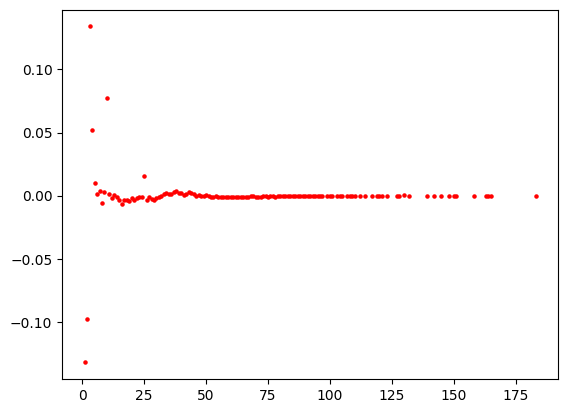

In [104]:
merged_df = pd.merge(alex_freq_table, hist_freq_table, left_on= 'alex_assignment_length', right_on = 'hist_assignment_length', how = 'right')
merged_df = merged_df[['hist_assignment_length', 'alex_frequency', 'hist_frequency']]
merged_df.columns = ['assignment_length', 'alex_frequency', 'hist_frequency']
merged_df['error'] = merged_df['alex_frequency'] -  merged_df['hist_frequency']

merged_df.to_csv('results/alex_hist_comparison.csv')
merged_df.head()

x = merged_df['assignment_length']
y1 = merged_df['alex_frequency']
y2= merged_df['hist_frequency']
y3= merged_df['error']

plt.scatter(x, y3, s=5, color='red')

#### based on this analysis, we observed under sampling for assignmens with sizes 1 and 2 and over sameling for assignment of size 3 and 4. The rest looks fine. 

# Computational time and improvment based on Alex analysis

In [105]:
alex_analysis["ExecutionTime"].mean()
alex_analysis["ExecutionTime"].max()
alex_analysis["ExecutionTime"].std()

11.627594026658912

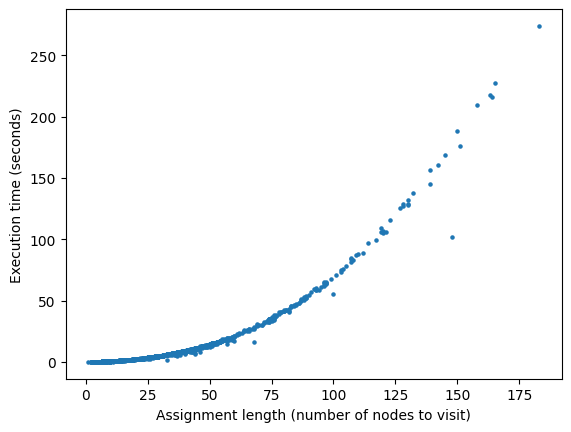

In [106]:
plt.scatter(alex_analysis["AssignmentLength"], alex_analysis["ExecutionTime"], s=5)
plt.xlabel("Assignment length (number of nodes to visit)")
plt.ylabel("Execution time (seconds)")
plt.savefig('plots/computational time.png')

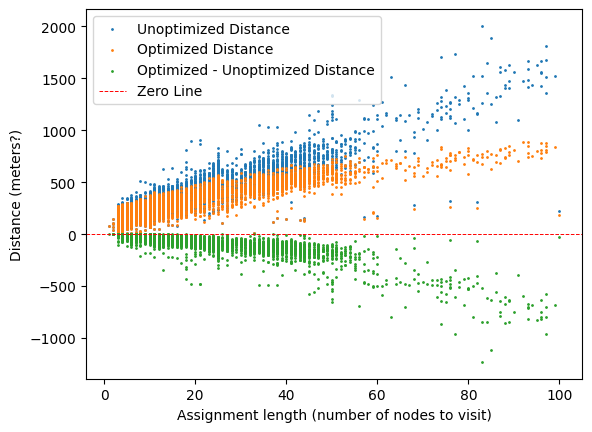

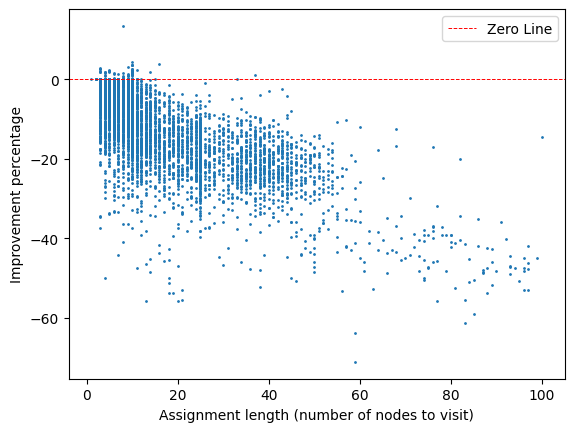

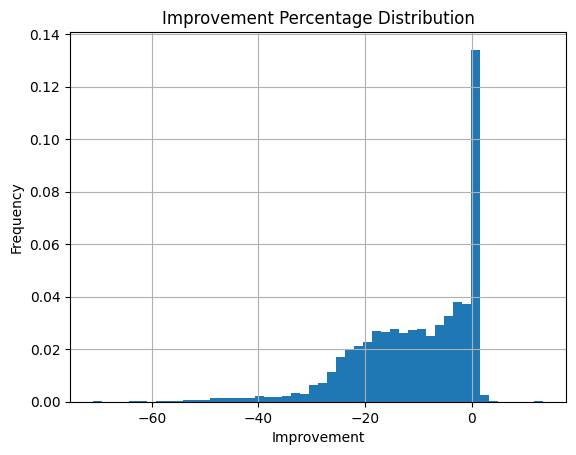

In [95]:
# filter the data you need 
data_df = alex_analysis[(alex_analysis['AssignmentLength']<=100)]
# data_df = alex_analysis

x = data_df["AssignmentLength"]
y1 = data_df["UnoptimizedDistance"]
y2 = data_df["OptimizedDistance"]
y3 = data_df["OptimizedDistance"] - data_df["UnoptimizedDistance"]
y4 = (data_df["OptimizedDistance"] - data_df["UnoptimizedDistance"])/data_df["UnoptimizedDistance"]*100

plt.scatter(x, y1, label="Unoptimized Distance", s=1)
plt.scatter(x, y2, label="Optimized Distance", s=1)
plt.scatter(x, y3, label="Optimized - Unoptimized Distance", s=1)
plt.axhline(0, color='red', linestyle='--', linewidth=0.7, label="Zero Line")
plt.xlabel("Assignment length (number of nodes to visit)")
plt.ylabel("Distance (meters?)")
plt.legend()
plt.savefig(f'plots/optimized versus unoptimized.png')
plt.show()

y4 = (data_df["OptimizedDistance"] - data_df["UnoptimizedDistance"])/data_df["UnoptimizedDistance"]*100
plt.scatter(x, y4, s=1)
plt.axhline(0, color='red', linestyle='--', linewidth=0.7, label="Zero Line")
plt.xlabel("Assignment length (number of nodes to visit)")
plt.ylabel("Improvement percentage")
plt.legend()
plt.savefig(f'plots/improvement percentage.png')
plt.show()

y4.hist(bins=50, density=True)
plt.xlabel("Improvement")
plt.ylabel("Frequency")
plt.title("Improvement Percentage Distribution")
plt.savefig(f'plots/improvement percentage distribution.png')
plt.show()

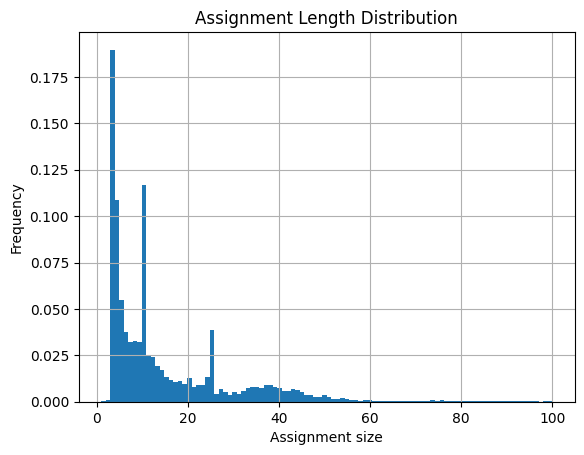

C:\Users\Hasan\AppData\Local\Temp\ipykernel_5928\1828024165.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['improv']= data_df['UnoptimizedDistance']-data_df['OptimizedDistance']


-0.06177865987487184

In [108]:
# Wighted improvment calculation

data_df['AssignmentLength'].hist(bins=100, density=True)

plt.xlabel("Assignment size")
plt.ylabel("Frequency")
plt.title("Assignment Length Distribution")
plt.savefig(f'plots/Assignment length distribution.png')
plt.show()

median = data_df['AssignmentLength'].median()
data_df['improv']= data_df['UnoptimizedDistance']-data_df['OptimizedDistance']

data_filtered = data_df[(data_df['improv']>=0) & (data_df['AssignmentLength']<=median)]
total_impr = (data_filtered['OptimizedDistance']-data_filtered['UnoptimizedDistance']).sum()/data_filtered['UnoptimizedDistance'].sum()
total_impr